In [25]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.preprocessing import preprocess

In [26]:
data_path = "../data/"
database = "final_merged_dataset.csv"
df = pd.read_csv(data_path + database)
df['Unnamed: 0'] = [i for i in range(len(df))] #c'est moche mais ca marche c'est la vie 
print(df.tail())

test = preprocess(df)

       Unnamed: 0                                              tweet  label
31996       31996  https://t.co/inx3HTRcfR Smell Diminishes by Da...      1
31997       31997  COVID-19 outbreak on the Diamond Princess crui...      1
31998       31998  Coronavirus China Italy | Coronavirus Outbreak...      1
31999       31999  Coronavirus Daily Digest: April 13, 2020\nhttp...      1
32000       32000  Detention centers are notorious for having poo...      1


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = df['tweet']
vectorizer = CountVectorizer(max_features = 100)
vectorizer.fit(corpus)
X = vectorizer.transform(corpus).toarray()
Y = df['label']

When we used TfIdf, performance dropped, so we just dropped it as well.

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(Y_pred, Y_test))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3446
           1       0.91      0.88      0.90      4555

    accuracy                           0.89      8001
   macro avg       0.88      0.89      0.88      8001
weighted avg       0.89      0.89      0.89      8001



(array([10860.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 13140.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

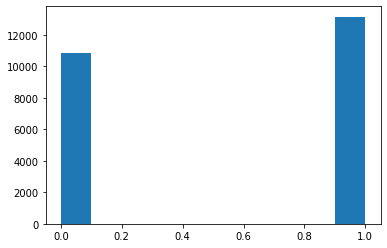

In [29]:
plt.hist(Y_train)

In [30]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, Y_pred))

[[3059  566]
 [ 347 4029]]


In [53]:
errors = pd.DataFrame({'location': [], 'text' :[], 'value': [], 'predicted': []})
for i in range(len(Y_pred)):
    if Y_test.values[i] - Y_pred[i] != 0:
        errors = errors.append({
            'location': Y_test.index[i],
            'text': df['tweet'][Y_test.index[i]],
            'predicted': Y_pred[i],
            'value': Y_test.values[i]
        }, ignore_index= True)
 
print(errors)

     location                                               text  value  \
0     12553.0  Man Finds It Difficult To Eat When Wearing A F...    0.0   
1     29762.0  The information minister was telling the media...    1.0   
2      5553.0  Pope Francis: COVID-19 crisis a chance to ‘com...    0.0   
3     21153.0  Did a COVID-19 Vaccine Killed Seven Children i...    0.0   
4     31637.0  @KSfan4life What is your question? We need to ...    1.0   
..        ...                                                ...    ...   
904    4018.0  Sir Ganga Ram Hospital has directed patients t...    0.0   
905    8440.0  Scientists find a parasite in the White House ...    0.0   
906    8953.0  RT @imperialcollege: @FraserNelson Thanks for ...    1.0   
907   25478.0  Is it allergies + migraine, or Covid-19? 🤔 Onl...    1.0   
908   25978.0  Labs in Pakistan continues to mint money by gi...    1.0   

     predicted  
0          1.0  
1          0.0  
2          1.0  
3          1.0  
4          0.0

In [54]:
for error in errors.head().iterrows():
    print('Sample error : \n', error[1]['text'], '\n')
    print('Line : ', error[1]['location'])
    print('Predicted value : ', error[1]['predicted'] , '\nReal value : ', error[1]['value'], '\n')
    print('_______________________________________________\n')

Sample error : 
 Man Finds It Difficult To Eat When Wearing A Face Mask https://t.co/atfaqxvfjX #coronavirus #facemasks #covid19 

Line :  12553.0
Predicted value :  1.0 
Real value :  0.0 

_______________________________________________

Sample error : 
 The information minister was telling the media about how many billions of naira that have given to their citizens. We cannot continue with all these lies and yet the government said people should not go out because of coronavirus covid-19 

Line :  29762.0
Predicted value :  0.0 
Real value :  1.0 

_______________________________________________

Sample error : 
 Pope Francis: COVID-19 crisis a chance to ‘come out better’ https://t.co/lPcwwDVpxp via @AJEnglish 

Line :  5553.0
Predicted value :  1.0 
Real value :  0.0 

_______________________________________________

Sample error : 
 Did a COVID-19 Vaccine Killed Seven Children in Senegal, Africa? - Weblyf https://t.co/xItVBoyM3N 

Line :  21153.0
Predicted value :  1.0 
Real value

In [55]:
words_error = []
for error in errors['text']:
    error_text = re.sub(r'[^\w\s]', '', error)
    words_error += word_tokenize(error_text)

my_stopwords = set(stopwords.words('english')) 

n = 2
words_error = [word for word in words_error if not word in my_stopwords]
ngram_all=(pd.Series(nltk.ngrams(words_error, n)).value_counts())[:30]
ngram_all=pd.DataFrame(ngram_all)
print(ngram_all)

                           0
(COVID19, vaccine)        17
(Vitamin, C)              17
(Government, Officially)  15
(Officially, Recommends)  15
(Recommends, Vitamin)     15
(C, COVID19)              15
(Shanghai, Government)    14
(Bill, Gates)             14
(novel, coronavirus)      11
(COVID, 19)               11
(corona, virus)           10
(coronavirus, outbreak)    8
(New, York)                8
(new, coronavirus)         8
(COVID19, coronavirus)     8
(new, cases)               7
(coronavirus, infection)   7
(Corona, virus)            7
(I, think)                 7
(Donald, Trump)            7
(wearing, face)            6
(face, masks)              6
(Infectious, Diseases)     6
(The, CDC)                 6
(Is, COVID19)              6
(United, States)           6
(recommend, wearing)       6
(coronavirus, vaccine)     6
(We, need)                 6
(due, COVID19)             6
